In [30]:
import os
import sys
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

# import seaborn as sns
# import yfinance as yf
# import pandas as pd
# import numpy as np
# import sys
# import os

plt.style.use('Solarize_Light2')

In [31]:
TICKERS = ['EURUSD=X', 'USDCHF=X']

def load_ticker_data():
    # end_date = '2024-10-16'
    # start_date = pd.to_datetime(end_date)-pd.DateOffset(364*2)

    if os.path.exists("data.csv"):
        _df = pd.read_csv("data.csv")
        _df['Datetime'] = pd.to_datetime(_df['Datetime'], utc=True)
        _df.set_index(['Datetime', 'Ticker'], inplace=True)
    else:
        _df = yf.download(
                tickers=TICKERS, 
                interval='1h', 
                period="max", 
                # start=start_date,
                # end=end_date
            ).stack(future_stack=True)
        _df.drop(columns=['Volume', 'Adj Close'], inplace=True)
        _df.to_csv("data.csv")

    _df.columns = _df.columns.str.lower()

    return _df

In [32]:
df = load_ticker_data()

df.head()

close      high       low      open
Datetime                  Ticker                                          
2022-10-17 18:00:00+00:00 EURUSD=X  0.985028  0.985028  0.984058  0.984349
                          USDCHF=X  0.995780  0.996630  0.995000  0.995990
2022-10-17 19:00:00+00:00 EURUSD=X  0.983865  0.984834  0.983478  0.984834
                          USDCHF=X  0.996340  0.996500  0.995300  0.995700
2022-10-17 20:00:00+00:00 EURUSD=X  0.984640  0.984737  0.983768  0.983768

In [33]:
# bool_df = df.isna()
# if not bool_df.loc[(bool_df['close'] == True) | (bool_df['high'] == True) | (bool_df['low'] == True) | (bool_df['open'] == True)].empty:
#     print("There is missing data")
#     sys.exit("There is missing data")

df.dropna(inplace=True)

In [34]:
df_pct_change = df.groupby(level=1).pct_change().dropna()

display(df_pct_change.xs(TICKERS[0], level=1).tail())
display(df_pct_change.xs(TICKERS[1], level=1).tail())

,close,high,low,open
Datetime,,,,
2024-10-16 14:00:00+00:00,-0.000871,-0.000654,-0.001196,0.000109
2024-10-16 15:00:00+00:00,-0.000653,-0.000979,-0.000543,-0.001088
2024-10-16 16:00:00+00:00,-0.000326,-0.000218,0.000000,-0.000544
2024-10-16 17:00:00+00:00,-0.000543,-0.000870,-0.000435,-0.000435
2024-10-16 18:00:00+00:00,-0.000543,-0.000435,-0.000543,-0.000543


,close,high,low,open
Datetime,,,,
2024-10-16 14:00:00+00:00,0.001867,0.002571,0.000023,-0.000823
2024-10-16 15:00:00+00:00,0.000058,-0.001155,0.001681,0.001994
2024-10-16 16:00:00+00:00,0.000498,0.000370,0.000139,-0.000012
2024-10-16 17:00:00+00:00,0.000289,-0.000092,0.000359,0.000463
2024-10-16 18:00:00+00:00,0.000451,0.000462,0.000463,0.000347


In [35]:
shape_df = {}

for ticker in TICKERS:
    shape_df[ticker] = df_pct_change.xs(ticker, level=1)['close']

pct_change_cols = pd.DataFrame(shape_df).dropna()

pct_change_cols.tail()

,EURUSD=X,USDCHF=X
Datetime,,
2024-10-16 14:00:00+00:00,-0.000871,0.001867
2024-10-16 15:00:00+00:00,-0.000653,0.000058
2024-10-16 16:00:00+00:00,-0.000326,0.000498
2024-10-16 17:00:00+00:00,-0.000543,0.000289
2024-10-16 18:00:00+00:00,-0.000543,0.000451


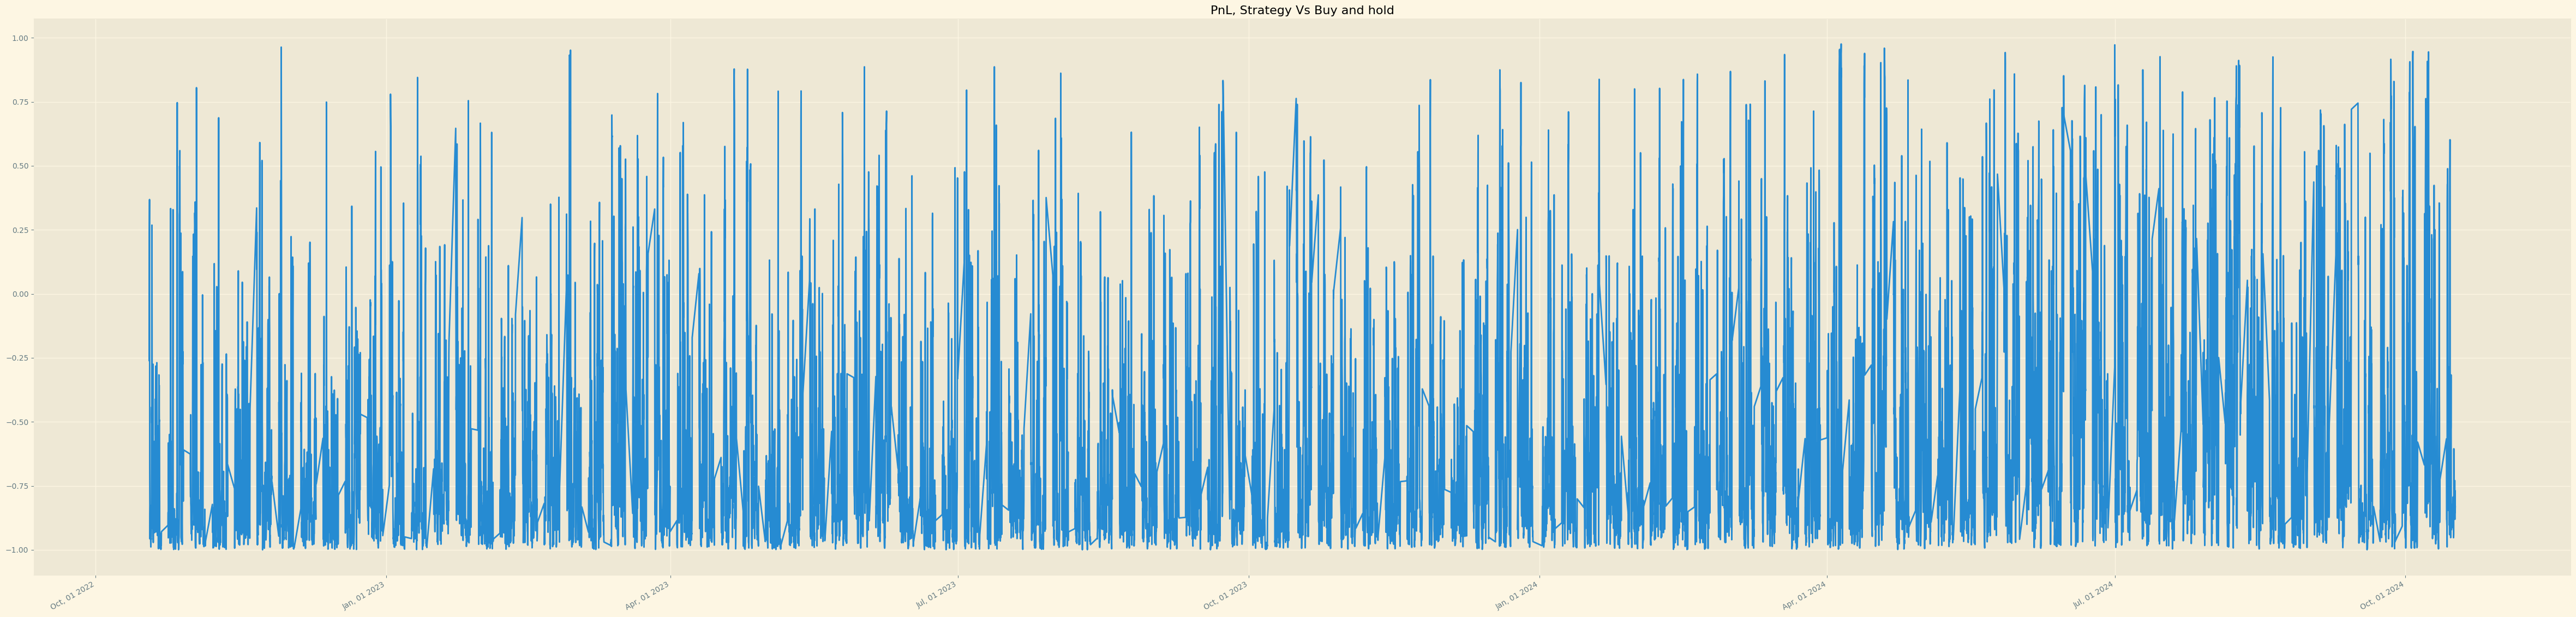

In [36]:
pct_change_cols['correlation'] = pct_change_cols[TICKERS[0]].rolling(window=5).corr(pct_change_cols[TICKERS[1]])
pct_change_cols['correlation'] = pct_change_cols['correlation'].shift(1)

pct_change_cols.dropna(inplace=True)

pct_change_cols['correlation'].plot(figsize=(60, 15), xlabel='')

plt.title('PnL, Strategy Vs Buy and hold')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)